In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["evtgen_v1_rec_v2", "spice_tau_reco"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
main_plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/compare_spice_ftp/output"
os.system(f"mkdir -p {main_plotting_path}")

0

In [7]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [8]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [9]:
keys_to_merge = {}

keys_to_merge["evtgen_v1_rec_v2"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["spice_tau_reco"] = {
    "NuE" : ["NuE_midE1", "NuE_highE1", "NuE_midE2", "NuE_highE2"],
    "NuMu" : ["NuMu_midE1", "NuMu_highE1","NuMu_midE2", "NuMu_highE2"],
    "NuTau" : ["NuTau_midE1", "NuTau_highE1","NuTau_midE2", "NuTau_highE2"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],

}

In [10]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE1
----- Extracting files for NuTau_highE1
----- Extracting files for NuTau_midE2
----- Extracting files for NuTau_highE2
----- Extracting files for NuE_midE1
----- Extracting files for NuE_highE1
----- Extracting files for NuE_midE2
----- Extracting files for NuE_highE2
----- Extracting files for NuMu_midE1
----- Extracting files for NuMu_highE1
----- Extracting files for NuMu_midE2
----- Extracting files for NuMu_highE2
----- Creating new key NuE
Using NuE_midE1
Using NuE_highE1
Using Nu

check if merging works now, seems to be fine

In [11]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[key] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                     astro_NuE    astro_NuMu   astro_NuTau            conv        prompt
evtgen_v1_rec_v2  56.20 ± 0.54  14.74 ± 0.22  33.91 ± 0.39  32.356 ± 0.968  12.47 ± 0.10
spice_tau_reco    56.77 ± 0.56  20.42 ± 0.22  34.89 ± 0.43  38.766 ± 0.947  13.41 ± 0.11


In [54]:
dataset_label_dict = {
    "evtgen_v1_rec_v2" : "ftp-v3",
    "spice_tau_reco" : "spice v3.2.1",
}

/tmp/ipykernel_26495/2050045718.py:59: RuntimeWarning: divide by zero encountered in divide
  ratio = hist_alternative / hist_baseline
/tmp/ipykernel_26495/2050045718.py:59: RuntimeWarning: invalid value encountered in divide
  ratio = hist_alternative / hist_baseline


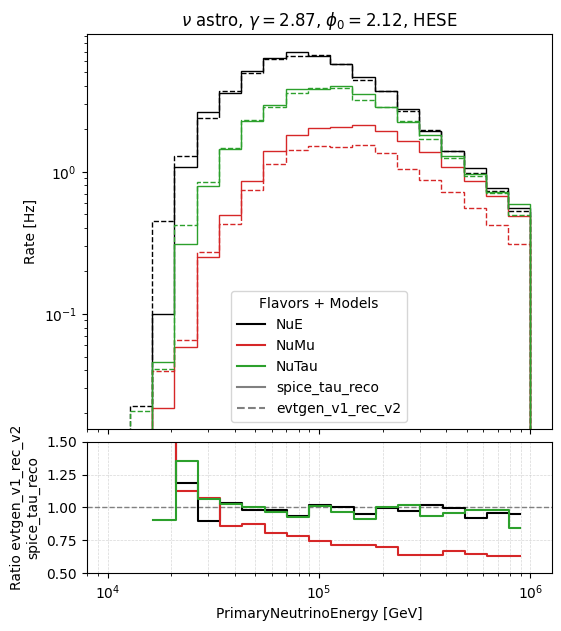

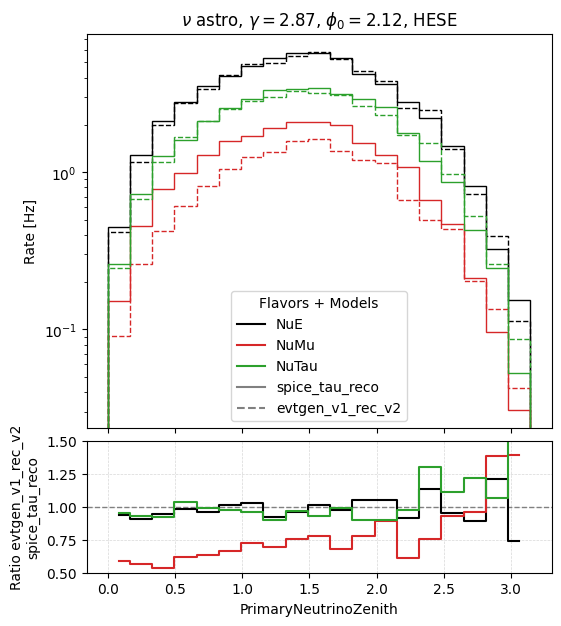

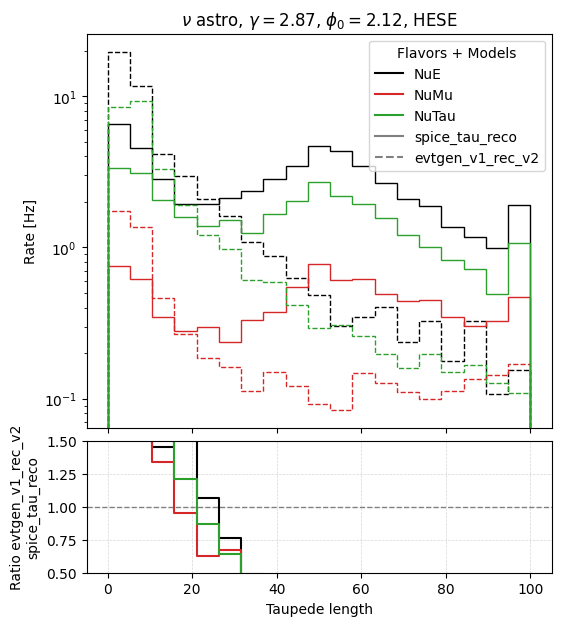

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

plotting_path = "/data/user/tvaneede/GlobalFit/reco_processing/notebooks/compare_spice_ftp/output/"

colors = ["black", "C3", "C2", "C1"]
 
def compare_ice_model( base_key = "spice_tau_reco",
                       base_var_key1 = "I3MCWeightDict", 
                       base_var_key2 = "PrimaryNeutrinoEnergy",
                       alt_key = "evtgen_v1_rec_v2",
                       alt_var_key1 = "I3MCWeightDict", 
                       alt_var_key2 = "PrimaryNeutrinoEnergy",
                       variable_name = "PrimaryNeutrinoEnergy [GeV]",
                       bins = np.geomspace(1e4, 1e6, 20),
                       xscale = "log", yscale = "log",
                       savename = "PrimaryNeutrinoEnergy.pdf"):

    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create subplots with shared x-axis
    fig = plt.figure(figsize=(6, 7))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax)

    ax.set_title(r"$\nu$ astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel("Rate [Hz]")

    # Lower plot: ratio
    ax_ratio.set_xscale(xscale)
    ax_ratio.set_ylabel(f"Ratio { dataset_label_dict[alt_key]}" + "\n" + f"{dataset_label_dict[base_key]}")
    ax_ratio.set_xlabel(variable_name)
    ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

    for i,flavor in enumerate(["NuE", "NuMu", "NuTau"]):

        var_baseline = simulation_datasets[base_key][flavor]["weighter"].get_column(base_var_key1, base_var_key2)
        var_alternative = simulation_datasets[alt_key][flavor]["weighter"].get_column(alt_var_key1, alt_var_key2)

        # Compute histograms
        hist_baseline, _    = np.histogram(var_baseline, 
                                           weights=simulation_datasets[base_key][flavor]["weights_astro"], 
                                           bins=bins )
        hist_alternative, _ = np.histogram(var_alternative, 
                                           weights=simulation_datasets[alt_key][flavor]["weights_astro"], 
                                           bins=bins )

        # Unweighted histogram, used for errors
        # counts_baseline, _ = np.histogram(var_baseline, bins=bins)
        # counts_alternative, _ = np.histogram(var_alternative, bins=bins)

        # Compute ratios
        ratio = hist_alternative / hist_baseline

        ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color=colors[i])

        # Upper plot: histograms
        ax.hist(var_baseline, 
                weights=simulation_datasets[base_key][flavor]["weights_astro"], 
                bins=bins, histtype="step", label=flavor, color=colors[i], linestyle="-")
        ax.hist(var_alternative, 
                weights=simulation_datasets[alt_key][flavor]["weights_astro"], 
                bins=bins, histtype="step", color=colors[i], linestyle="--")


    # Improve layout
    plt.setp(ax.get_xticklabels(), visible=False)
    ax_ratio.set_ylim(0.5, 1.5)  # adjust as needed
    ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

    # Custom legend for ice model types
    flavor_lines = [
        Line2D([0], [0], color=colors[i], linestyle='-', label=flavor)
        for i, flavor in enumerate(["NuE", "NuMu", "NuTau"])
    ]

    # Ice model style legend (linestyles)
    style_lines = [
        Line2D([0], [0], color='gray', linestyle='-', label=base_key),
        Line2D([0], [0], color='gray', linestyle='--', label=alt_key)
    ]


    ax.legend(handles=flavor_lines + style_lines, loc="best", frameon=True, title="Flavors + Models")

    plt.savefig(f"{plotting_path}/{savename}")

    plt.show()

# true variables
compare_ice_model( base_key = "spice_tau_reco", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoEnergy",
                   alt_key = "evtgen_v1_rec_v2", alt_var_key1 = "I3MCWeightDict", alt_var_key2 = "PrimaryNeutrinoEnergy",
                   variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e4, 1e6, 20), xscale = "log", yscale = "log", savename="PrimaryNeutrinoEnergy.pdf" )

compare_ice_model( base_key = "spice_tau_reco", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoZenith",
                   alt_key = "evtgen_v1_rec_v2", alt_var_key1 = "I3MCWeightDict", alt_var_key2 = "PrimaryNeutrinoZenith",
                   variable_name = "PrimaryNeutrinoZenith", bins = np.linspace(0, np.pi, 20), xscale = "linear", yscale = "log", savename="PrimaryNeutrinoZenith.pdf" )


# reco variables
compare_ice_model( base_key = "spice_tau_reco", base_var_key1 = "HESETaupedeFit", base_var_key2 = "length",
                   alt_key = "evtgen_v1_rec_v2", alt_var_key1 = "TaupedeFit_iMIGRAD_PPB0", alt_var_key2 = "length",
                   variable_name = "Taupede length", bins = np.linspace(0, 100, 20), xscale = "linear", yscale = "log", savename="TaupedeLength.pdf" )